# ROMY & FUR - Overview

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch
from pandas import read_pickle, DataFrame

from functions.get_time_intervals import __get_time_intervals
from functions.load_bathymetry import __load_bathymetry

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
config = {}

config['tbeg'] = UTCDateTime("2023-09-20")
config['tend'] = UTCDateTime("2023-09-27")

# config['tbeg'] = UTCDateTime("2023-12-15")
# config['tend'] = UTCDateTime("2023-12-31")

config['path'] = data_path+"VelocityChanges/data/all/"
# config['path_all'] = data_path+"VelocityChanges/data/all/"

config['path_to_figs'] = data_path+"VelocityChanges/figures/"

config['path_to_bathy_data'] = data_path+"VelocityChanges/data/bathymetry/"

config['romy_lon'], config['romy_lat'] = 11.275501, 48.162941


### Load Data

In [4]:
dates = __get_time_intervals(config['tbeg'], config['tend'], interval_seconds=86400, interval_overlap=0)
# dates = __get_time_intervals(config['tbeg'], config['tbeg']+86400, interval_seconds=86400, interval_overlap=0)


baz_love, baz_rayleigh, baz_tangent, baz_bf = np.array([]), np.array([]), np.array([]), np.array([])
vel_love, vel_rayleigh, vel_bf = np.array([]), np.array([]), np.array([])
std_love, std_rayleigh, std_bf = np.array([]), np.array([]), np.array([])
cc_love, cc_rayleigh, cc_bf, cc_tangent = np.array([]), np.array([]), np.array([]), np.array([])
ttt, ttt_bf = np.array([]), np.array([])

for _n, (d1, d2) in enumerate(dates):

    filename = f"VC_BAZ_{d1.date}_all.pkl"

    if os.path.isfile(config['path']+filename):
        print(f"loading: {filename}")
        out = read_pickle(config['path']+filename)
    else:
        print(f"-> no file for {filename}")

    # print(out.keys())

    try:
        vel_love = np.append(vel_love, out['vel_love_all'])
        vel_rayleigh = np.append(vel_rayleigh, out['vel_rayleigh_all'])
        vel_bf = np.append(vel_bf, out['vel_bf_all'])

        baz_love = np.append(baz_love, out['baz_love_all'])
        baz_rayleigh = np.append(baz_rayleigh, out['baz_rayleigh_all'])
        baz_tangent = np.append(baz_tangent, out['baz_tangent_all'])
        baz_bf = np.append(baz_bf, out['baz_bf_all'])

        cc_love = np.append(cc_love, out['cc_love_all'])
        cc_rayleigh = np.append(cc_rayleigh, out['cc_rayleigh_all'])
        cc_tangent = np.append(cc_tangent, out['cc_tangent_all'])


        ttt = np.append(ttt, out['time'])
        ttt_bf = np.append(ttt_bf, out['time_bf'])

    except:
        print(f" -> skipping: {filename}")
        continue

## remove nan values based on time array
# bad = []
# for _i, tt in enumerate(ttt):
#     if str(type(tt)) != "<class 'obspy.core.utcdatetime.UTCDateTime'>":
#         bad.append(_i)



loading: VC_BAZ_2023-09-20_all.pkl
loading: VC_BAZ_2023-09-21_all.pkl
loading: VC_BAZ_2023-09-22_all.pkl
loading: VC_BAZ_2023-09-23_all.pkl
loading: VC_BAZ_2023-09-24_all.pkl
loading: VC_BAZ_2023-09-25_all.pkl
-> no file for VC_BAZ_2023-09-26_all.pkl


### Make DataFrames

In [5]:
## _____________________________
df_rayleigh = DataFrame()

df_rayleigh['time'] = ttt
df_rayleigh['cc'] = cc_rayleigh
df_rayleigh['vel'] = vel_rayleigh
df_rayleigh['baz'] = baz_rayleigh


df_rayleigh = df_rayleigh.dropna(subset=['time']).reset_index()

df_rayleigh['time_relative'] = df_rayleigh.time - df_rayleigh.time.iloc[0]

## _____________________________
df_love = DataFrame()

df_love['time'] = ttt
df_love['cc'] = cc_love
df_love['vel'] = vel_love
df_love['baz'] = baz_love

df_love = df_love.dropna(subset=['time']).reset_index()

df_love['time_relative'] = df_love.time - df_love.time.iloc[0]

## _____________________________
df_tangent = DataFrame()

df_tangent['time'] = ttt
df_tangent['cc'] = cc_tangent
df_tangent['baz'] = baz_tangent

df_tangent = df_tangent.dropna(subset=['time']).reset_index()

df_tangent['time_relative'] = df_tangent.time - df_tangent.time.iloc[0]

## _____________________________
df_bf = DataFrame()

df_bf['time'] = ttt_bf
df_bf['baz'] = baz_bf
df_bf['vel'] = vel_bf

df_bf = df_bf.dropna(subset=['time']).reset_index()

df_bf['time_relative'] = df_bf.time - df_bf.time.iloc[0]


#### Filter Frames

In [6]:
cc_threshold = 0.7

df_tangent = df_tangent[df_tangent.cc > cc_threshold]
df_rayleigh = df_rayleigh[df_rayleigh.cc > cc_threshold]
df_love = df_love[df_love.cc > cc_threshold]
# df_bf = df_bf[df_bf.cc > cc_threshold]


## Plotting

/tmp/ipykernel_486902/2039898074.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  im3 = ax[3].scatter(df_bf.time_relative*time_scaling, df_bf.baz,
/tmp/ipykernel_486902/2039898074.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


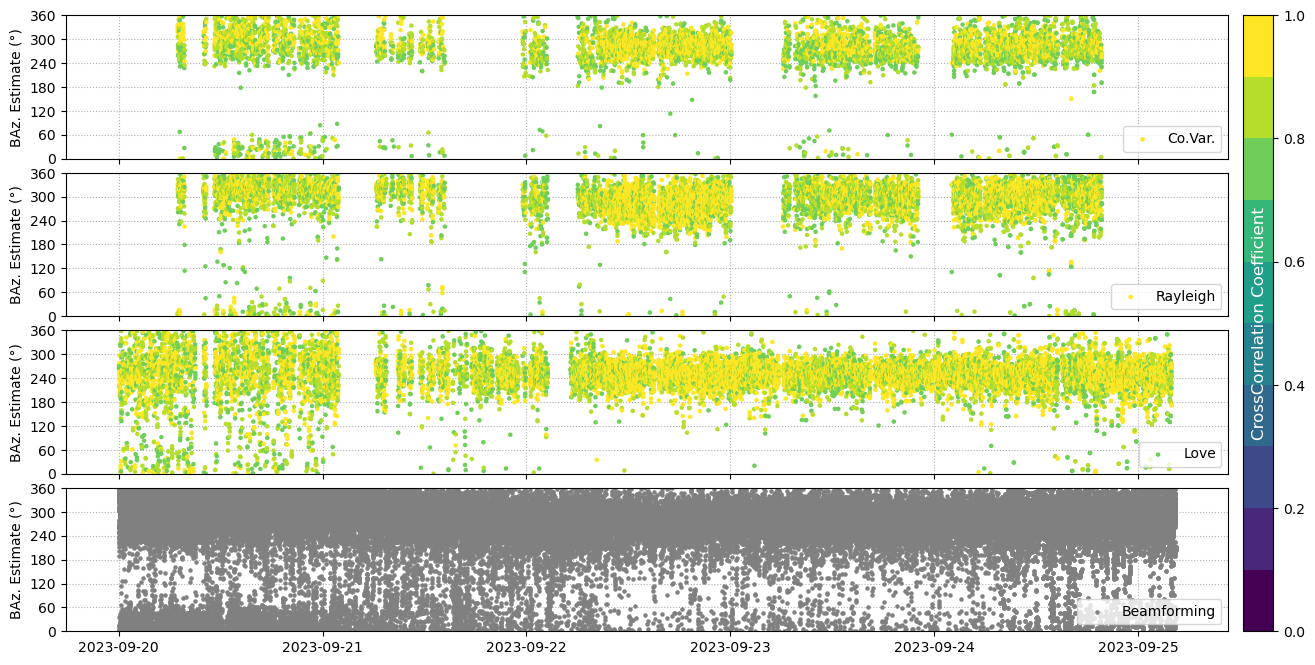

In [7]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    cmap = plt.get_cmap("viridis", 10)

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    im0 = ax[0].scatter(df_tangent.time_relative*time_scaling, df_tangent.baz,
                        c=df_tangent.cc, s=5, label="Co.Var.", zorder=2, cmap=cmap, vmin=0, vmax=1)
    im1 = ax[1].scatter(df_rayleigh.time_relative*time_scaling, df_rayleigh.baz,
                        c=df_rayleigh.cc, s=5, label="Rayleigh", zorder=2, cmap=cmap, vmin=0, vmax=1)
    im2 = ax[2].scatter(df_love.time_relative*time_scaling, df_love.baz,
                        c=df_love.cc, s=5, label="Love", zorder=2, cmap=cmap, vmin=0, vmax=1)
    im3 = ax[3].scatter(df_bf.time_relative*time_scaling, df_bf.baz,
                        color="grey", s=5, label="Beamforming", zorder=2, cmap=cmap, vmin=0, vmax=1)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=4)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("BAz. Estimate (°)")
        # ax[_n].set_xlim(left=0)

    # ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax)
    cb.set_label("CrossCorrelation Coefficient", fontsize=font, labelpad=-38, color="white")

    ## add dates for x-axis
    ref_date = config['tbeg']
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str((UTCDateTime(ref_date)+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}_all.png", format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_486902/3555101476.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


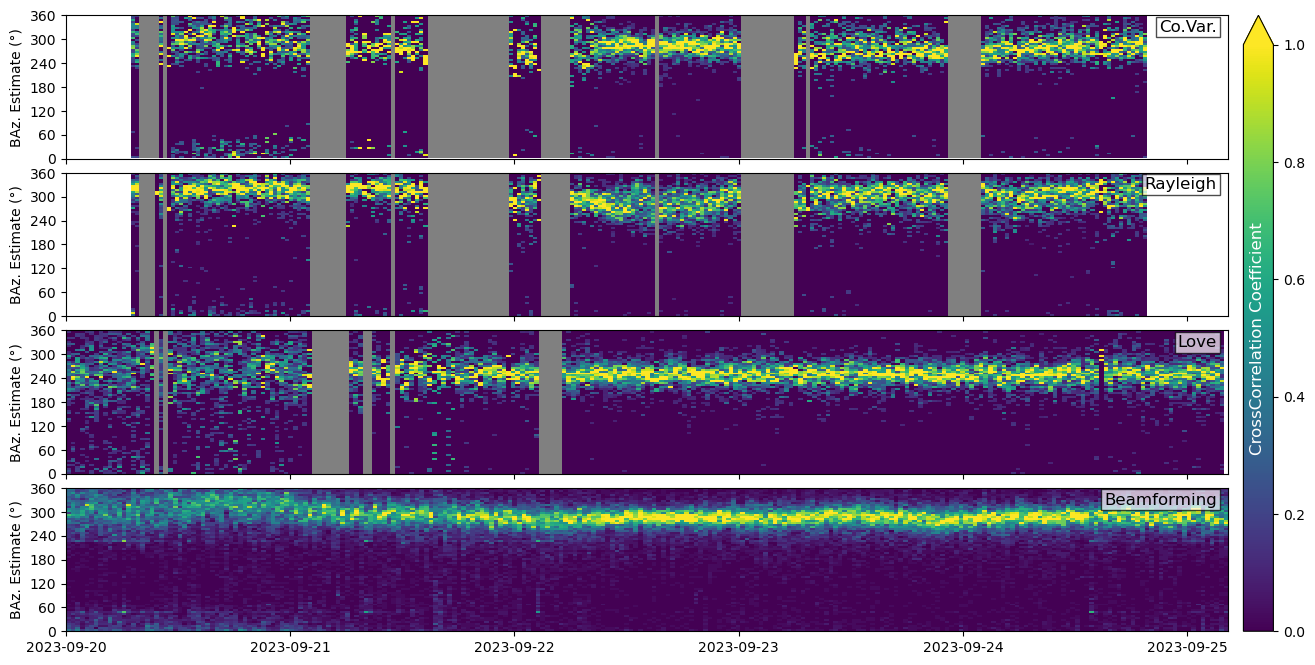

In [8]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    cmap = plt.get_cmap("viridis")
    cmap.set_bad("grey")

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    norm_fac = 10

    nx = 250
    ny = 72

    ## ----------------------------------------------
    hist0, x0, y0 = np.histogram2d(np.nan_to_num(df_tangent.time_relative, 0),
                                   np.nan_to_num(df_tangent.baz, 0),
                                   bins=(nx, ny),
                                   weights=np.nan_to_num(df_tangent.cc, 0)
                                  )
    hist0 = hist0.T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist0 *= norm_fac / hist0.sum(axis=0, keepdims=True)

    im0 = ax[0].pcolormesh(x0, y0, hist0, cmap=cmap, vmin=0, vmax=1)


    ## ----------------------------------------------
    hist1, x1, y1 = np.histogram2d(np.nan_to_num(df_rayleigh.time_relative, 0),
                                   np.nan_to_num(df_rayleigh.baz, 0),
                                   bins=(nx, ny),
                                   weights=np.nan_to_num(df_rayleigh.cc, 0)
                                  )
    hist1 = hist1.T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist1 *= norm_fac / hist1.sum(axis=0, keepdims=True)

    im1 = ax[1].pcolormesh(x1, y1, hist1, cmap=cmap, vmin=0, vmax=1)


    ## ----------------------------------------------
    hist2, x2, y2 = np.histogram2d(np.nan_to_num(df_love.time_relative, 0),
                                   np.nan_to_num(df_love.baz, 0),
                                   bins=(nx, ny),
                                   weights=np.nan_to_num(df_love.cc, 0)
                                  )
    hist2 = hist2.T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist2 *= norm_fac / hist2.sum(axis=0, keepdims=True)

    im2 = ax[2].pcolormesh(x2, y2, hist2, cmap=cmap, vmin=0, vmax=1)


    ## ----------------------------------------------
    hist3, x3, y3 = np.histogram2d(np.nan_to_num(df_bf.time_relative, 0),
                                   np.nan_to_num(df_bf.baz, 0),
                                   bins=(nx, ny),
                                   # weights=np.nan_to_num(df_bf.cc, 0)
                                  )
    hist3 = hist3.T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist3 *= norm_fac / hist3.sum(axis=0, keepdims=True)

    im3 = ax[3].pcolormesh(x3, y3, hist3, cmap=cmap, vmin=0, vmax=1)

#     _, _, _, im0 = ax[0].hist2d(
#                                 np.nan_to_num(df_tangent.time_relative, 0),
#                                 np.nan_to_num(df_tangent.baz, 0),
#                                 weights=np.nan_to_num(df_tangent.cc, 0),
#                                 bins=[nx,ny], label="Co.Var.",
#                                 zorder=2, cmap=cmap, density=True,
#                                 # norm=colors.LogNorm(vmin=1e-8, vmax=1e-6),
#                                 # norm=colors.Normalize(vmin=0, vmax=1)
#     );

#     _, _, _, im1  = ax[1].hist2d(
#                                 np.nan_to_num(df_rayleigh.time_relative, 0),
#                                 np.nan_to_num(df_rayleigh.baz, 0),
#                                 weights=np.nan_to_num(df_rayleigh.cc, 0),
#                                 bins=[nx,ny], label="Rayleigh",
#                                 zorder=2, cmap=cmap, density=True,
#                                 # norm=colors.LogNorm(),
#     );

#     _, _, _, im2  = ax[2].hist2d(
#                                 np.nan_to_num(df_love.time_relative, 0),
#                                 np.nan_to_num(df_love.baz, 0),
#                                 weights=np.nan_to_num(df_love.cc, 0),
#                                 bins=[nx,ny], label="Love",
#                                 zorder=2, cmap=cmap, density=True,
#                                 # norm=colors.LogNorm(),
#     );

#     _, _, _, im3  = ax[3].hist2d(
#                                 np.nan_to_num(df_bf.time_relative, 0),
#                                 np.nan_to_num(df_bf.baz, 0),
#                                 bins=[nx,ny], label="Beamforming",
#                                 zorder=2, cmap=cmap, density=True,
#                                 # norm=colors.LogNorm(),
#     );

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=4)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("BAz. Estimate (°)")
        ax[_n].set_xlim(left=0)

    ax[0].text(.99, .97, 'Co.Var.', color="k", ha='right', va='top', transform=ax[0].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[1].text(.99, .97, 'Rayleigh', color="k", ha='right', va='top', transform=ax[1].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[2].text(.99, .97, 'Love', color="k", ha='right', va='top', transform=ax[2].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[3].text(.99, .97, 'Beamforming', color="k", ha='right', va='top', transform=ax[3].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im0, cax=cbar_ax, extend="max")
    cb.set_label("CrossCorrelation Coefficient", fontsize=font, labelpad=-40, color="white")



    ## add dates for x-axis
    ref_date = config['tbeg']
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str((UTCDateTime(ref_date)+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    # ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}_all.png", format="png", dpi=150, bbox_inches='tight')


In [9]:
def circular_hist(ax, x, nbins=72, density=True, offset=0, gaps=True, weights=None):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        nbins = np.linspace(-np.pi, np.pi, num=nbins+1)

    # Bin data and record counts
    if weights is not None:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi), weights=weights)
    else:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi))

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths,
                     edgecolor='darkred', fill=False, linewidth=0.5, bottom=1.0)

    # Set the direction of the zero angle
    # ax.set_theta_offset(offset)
    ax.set_theta_zero_location("N")  # theta=0 at the top

    ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.grid(zorder=0)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

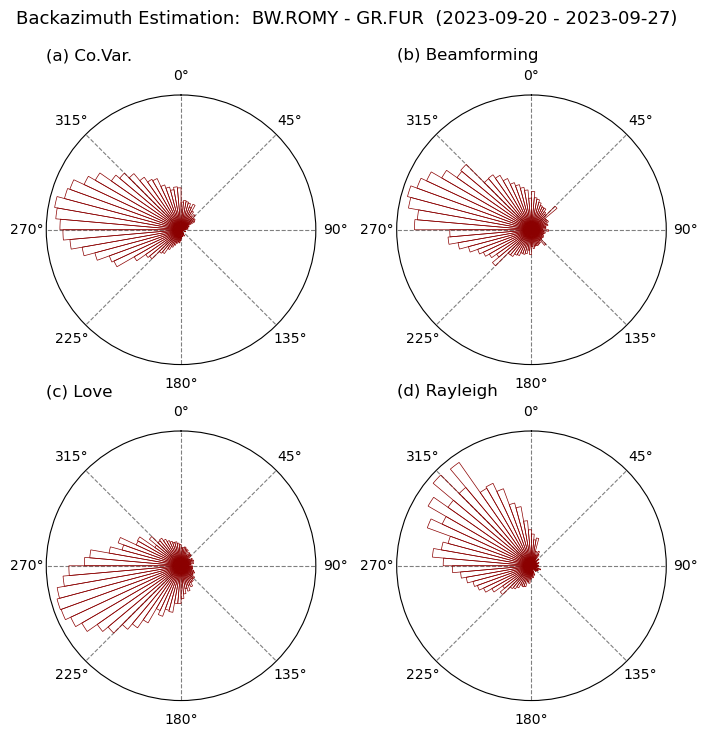

In [10]:
def __makeplot_polar(density=False):

    import matplotlib.pyplot as plt
    import numpy as np

    font = 12

    # weight = False

    # Construct figure and axis to plot on
    fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection='polar'), figsize=(8, 8))

    plt.subplots_adjust(wspace=0.3)

    circular_hist(ax[0,0], np.deg2rad(df_tangent.baz), density=density)
    circular_hist(ax[0,1], np.deg2rad(df_bf.baz), density=density)
    circular_hist(ax[1,0], np.deg2rad(df_love.baz), density=density)
    circular_hist(ax[1,1], np.deg2rad(df_rayleigh.baz), density=density)

    ax[0,0].set_title("(a) Co.Var.", loc="left")
    ax[0,1].set_title("(b) Beamforming", loc="left")
    ax[1,0].set_title("(c) Love", loc="left")
    ax[1,1].set_title("(d) Rayleigh", loc="left")

    for i in range(2):
        for j in range(2):
            ax[i,j].grid(color="k", zorder=0, ls="--", alpha=0.5)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_polar(density=True)

fig.savefig(config['path_to_figs']+f"BAZ_polar_{config['tbeg'].date}_{config['tend'].date}_all.png", format="png", dpi=150, bbox_inches='tight')


### Plot on Map

In [11]:
box = [config['romy_lon']-40, config['romy_lon']+40, config['romy_lat']-40, config['romy_lat']+40]

out_bath = __load_bathymetry(config['path_to_bathy_data'], (box[0], box[2], box[1], box[3]))


In [12]:
def __makeplot_maps(density=False):

    import gc
    import matplotlib.colors
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import matplotlib.pyplot as mpl
    import cartopy.feature as cfeature

    romy_lon = 11.275501
    romy_lat = 48.162941

    flatMap = ccrs.PlateCarree()

    resolution = '50m'

    box = [romy_lon-40, romy_lon+40, romy_lat-40, romy_lat+40]

    ## load bathymetry data
    # out_bath = __load_bathymetry(config['path_to_bathy_data'], (box[0], box[2], box[1], box[3]))


    font = 12

    fig = plt.figure(figsize=(10, 10), dpi=96)

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    ## ________________________________________________
    ## CoVar

    ax0 = fig.add_subplot(221, projection=flatMap)

    ax0.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    # ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax00 = fig.add_subplot(221, projection='polar')


    circular_hist(ax00, np.deg2rad(df_tangent.baz), density=density, weights=df_tangent.cc)

    ax00.patch.set_alpha(0.)
    ax00.grid(color="k", ls="--", alpha=0.5)

    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax0.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax0.set_rasterized(True)

    ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax0.add_feature(cfeature.LAND, color='grey')
    ax0.coastlines(lw=0.5, resolution=resolution)
    ax0.set_rasterized(True)

    # ax000 = fig.add_subplot(221, projection=ccrs.PlateCarree())
    # ax000.pcolormesh(lon, lat, img, transform=ccrs.PlateCarree())

    ## ________________________________________________
    ## Beamforming

    ax1 = fig.add_subplot(222, projection=flatMap)

    ax1.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))


    ax01 = fig.add_subplot(222, projection='polar')


    circular_hist(ax01, np.deg2rad(df_bf.baz), density=density)

    ax01.patch.set_alpha(0.)
    ax01.grid(color="k", ls="--", alpha=0.5)


    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax1.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax1.set_rasterized(True)

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax1.add_feature(cfeature.LAND, color='grey')
    ax1.coastlines(lw=0.5, resolution=resolution)
    ax1.set_rasterized(True)


    ## ________________________________________________
    ## Love

    ax2 = fig.add_subplot(223, projection=flatMap)

    ax2.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax02 = fig.add_subplot(223, projection='polar')

    circular_hist(ax02, np.deg2rad(df_love.baz), density=density, weights=df_love.cc)

    ax02.patch.set_alpha(0.)
    ax02.grid(color="k", ls="--", alpha=0.5)


    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax2.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax2.set_rasterized(True)

    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax2.add_feature(cfeature.LAND, color='grey')
    ax2.coastlines(lw=0.5, resolution=resolution)
    ax2.set_rasterized(True)


    ## ________________________________________________
    ## Rayleigh

    ax3 = fig.add_subplot(224, projection=flatMap)


    ax3.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    # ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax03 = fig.add_subplot(224, projection='polar')

    circular_hist(ax03, np.deg2rad(df_rayleigh.baz), density=density, weights=df_rayleigh.cc)


    ax03.patch.set_alpha(0.)
    ax03.grid(color="k", ls="--", alpha=0.5)

    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax3.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax3.set_rasterized(True)

    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax3.add_feature(cfeature.LAND, color='grey')
    ax3.coastlines(lw=0.5, resolution=resolution)
    ax3.set_rasterized(True)



    ax0.set_title("(a) Co-Variance", pad=15, loc="left", fontsize=font)
    ax1.set_title("(b) Beamforming", pad=15, loc="left", fontsize=font)
    ax2.set_title("(c) Love waves", pad=15, loc="left", fontsize=font)
    ax3.set_title("(d) Rayleigh waves", pad=15, loc="left", fontsize=font)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1, y=0.95)

    gc.collect()

    plt.show();
    return fig

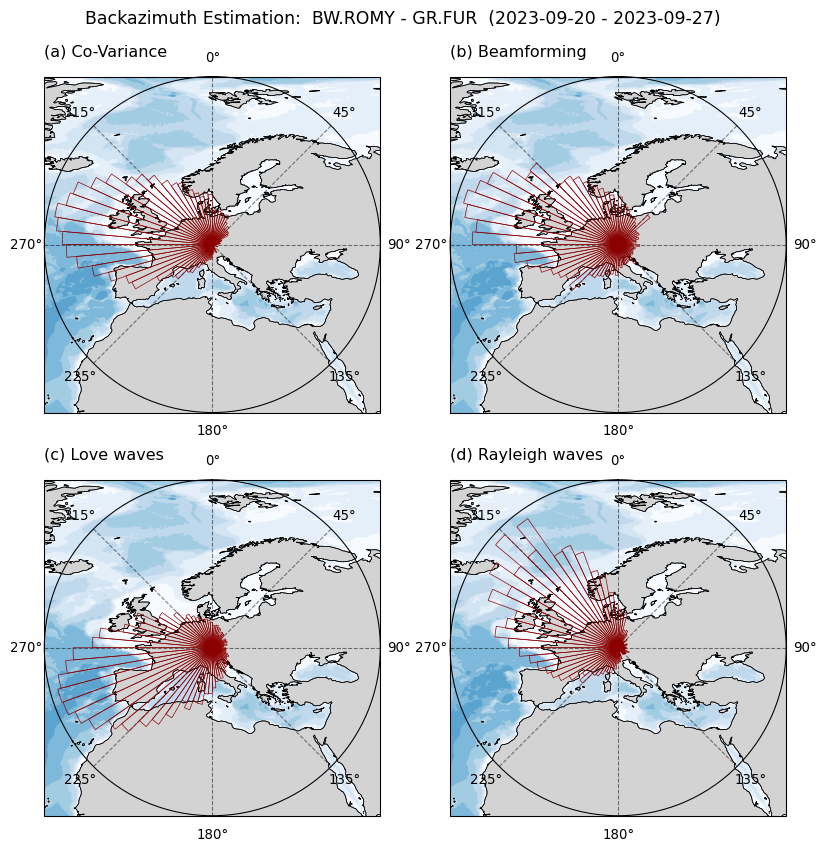

In [13]:
fig = __makeplot_maps(density=True)

fig.savefig(config['path_to_figs']+f"BAZ_maps_{config['tbeg'].date}_{config['tend'].date}_all.png", format="png", dpi=150, bbox_inches='tight')

## Velocities

/tmp/ipykernel_486902/387646478.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


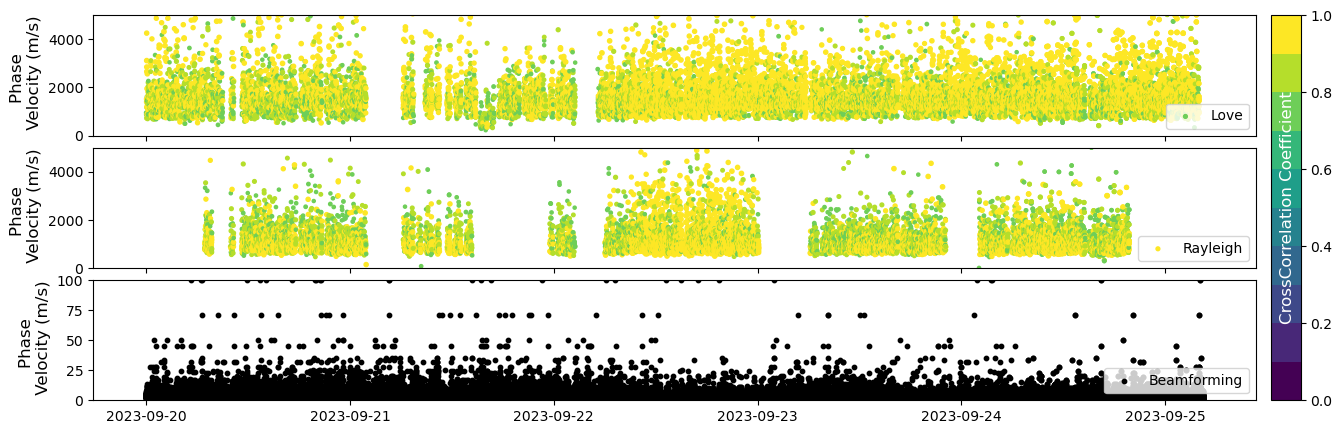

In [14]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    cmap = plt.get_cmap("viridis", 10)

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    im0 = ax[0].scatter(df_love.time_relative*time_scaling, df_love.vel,
                        s=10**df_love.cc, c=df_love.cc, label="Love", cmap=cmap, vmin=0, vmax=1)

    ax[1].scatter(df_rayleigh.time_relative*time_scaling, df_rayleigh.vel,
                  s=10**df_rayleigh.cc, c=df_rayleigh.cc, label="Rayleigh", cmap=cmap, vmin=0, vmax=1)

    ax[2].scatter(df_bf.time_relative*time_scaling, 1/df_bf.vel,
                  s=10, c="k", label="Beamforming")

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0, which="both")
        ax[_n].legend(loc=4, fontsize=font-2)
        if _n < 2:
            ax[_n].set_ylim(0, 5000)
        else:
            ax[_n].set_ylim(0, 100)

        # ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("Phase \n Velocity (m/s)", fontsize=font)
        # ax[_n].set_xlim(left=0)
        # ax[_n].set_yscale("log")

    # ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im0, cax=cbar_ax)
    cb.set_label("CrossCorrelation Coefficient", fontsize=font, labelpad=-38, color="white")

    ## add dates for x-axis
    ref_date = config['tbeg']
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str((UTCDateTime(ref_date)+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BAZ_velocities_{config['tbeg'].date}_{config['tend'].date}_all.png", format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_486902/4010095283.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


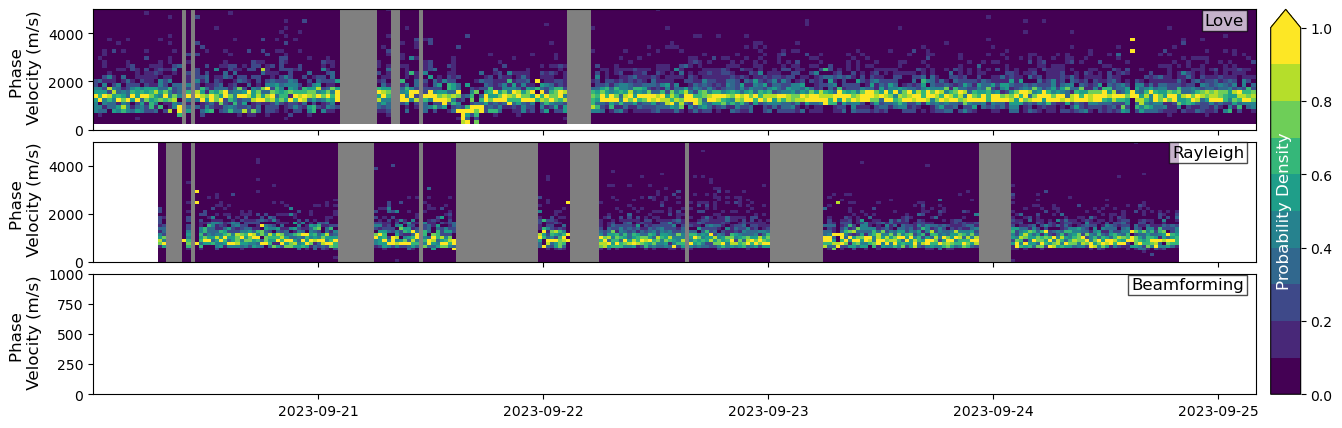

In [15]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    cmap = plt.get_cmap("viridis", 10)
    # cmap = plt.get_cmap("viridis")
    cmap.set_bad("grey")

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    norm_fac = 5

    nx = 250
    ny = 72

    ## ----------------------------------------------
    hist0, x0, y0 = np.histogram2d(np.nan_to_num(df_love.time_relative, 0),
                                   np.nan_to_num(df_love.vel, 0),
                                   bins=(nx, ny),
                                   weights=np.nan_to_num(df_love.cc, 0)
                                  )
    hist0 = hist0.T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist0 *= norm_fac / hist0.sum(axis=0, keepdims=True)

    im0 = ax[0].pcolormesh(x0, y0, hist0, cmap=cmap, vmin=0, vmax=1)

    ## ----------------------------------------------
    hist1, x1, y1 = np.histogram2d(np.nan_to_num(df_rayleigh.time_relative, 0),
                                   np.nan_to_num(df_rayleigh.vel, 0),
                                   bins=(nx, ny),
                                   weights=np.nan_to_num(df_rayleigh.cc, 0)
                                  )
    hist1 = hist1.T
    with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
        hist1 *= norm_fac / hist1.sum(axis=0, keepdims=True)

    im1 = ax[1].pcolormesh(x1, y1, hist1, cmap=cmap, vmin=0, vmax=1)

#     _, _, _, im0 = ax[0].hist2d(
#                                 np.nan_to_num(df_love.time_relative, 0),
#                                 np.nan_to_num(df_love.vel, 0),
#                                 weights=np.nan_to_num(df_love.cc, 0),
#                                 bins=[nx,ny], label="Co.Var.",
#                                 zorder=2, cmap=cmap, density=True, cmin=0,
#                                 norm=colors.LogNorm(),
#     );

#     _, _, _, im1 = ax[1].hist2d(
#                                 np.nan_to_num(df_rayleigh.time_relative, 0),
#                                 np.nan_to_num(df_rayleigh.vel, 0),
#                                 weights=np.nan_to_num(df_rayleigh.cc, 0),
#                                 bins=[nx,ny], label="Co.Var.",
#                                 zorder=2, cmap=cmap, density=True, cmin=0,
#                                 norm=colors.LogNorm(),
#     );

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0, which="both")
        # ax[_n].legend(loc=4, fontsize=font-2)
        if _n < 2:
            ax[_n].set_ylim(0, 5000)
        else:
            ax[_n].set_ylim(0, 1000)

        # ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("Phase \n Velocity (m/s)", fontsize=font)
        # ax[_n].set_xlim(left=0)
        # ax[_n].set_yscale("log")

    ax[0].text(.99, .97, 'Love', color="k", ha='right', va='top', transform=ax[0].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[1].text(.99, .97, 'Rayleigh', color="k", ha='right', va='top', transform=ax[1].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})
    ax[2].text(.99, .97, 'Beamforming', color="k", ha='right', va='top', transform=ax[2].transAxes, fontsize=font, bbox={'facecolor':'w', 'alpha':0.7, 'pad':2})


    # ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im0, cax=cbar_ax, extend="max")
    cb.set_label("Probability Density", fontsize=font, labelpad=-40, color="white")

    ## add dates for x-axis
    ref_date = config['tbeg']
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str((UTCDateTime(ref_date)+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BAZ_velocities_{config['tbeg'].date}_{config['tend'].date}_all.png", format="png", dpi=150, bbox_inches='tight')


In [16]:
import netCDF4

path_to_swh_data = data_path+"VelocityChanges/data/SWH/"

f = netCDF4.Dataset(path_to_swh_data+'cmems_obs-wave_glo_phy-swh_nrt_multi-l4-2deg_P1D.nc')

f.variables.keys()

dict_keys(['VAVH_DAILY_MAX', 'VAVH_DAILY_MEAN', 'VAVH_DAILY_NBR', 'VAVH_DAILY_STD', 'VAVH_INST', 'VAVH_INST_NBR', 'VAVH_INST_SCORE', 'latitude', 'longitude', 'time'])

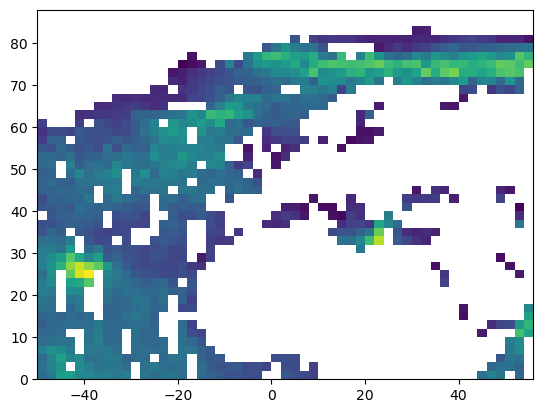

In [17]:
lat, lon = f.variables['latitude'], f.variables['longitude']

img = f.variables['VAVH_DAILY_MEAN'][10].data


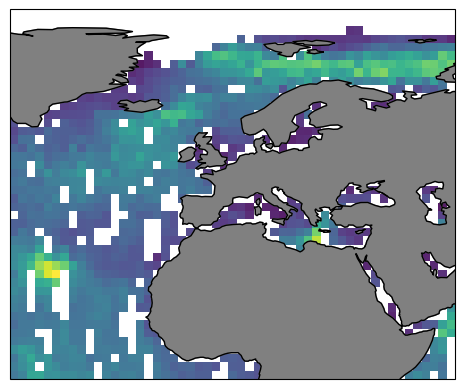

In [18]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())

ax.pcolormesh(lon, lat, img, transform=ccrs.PlateCarree(), alpha=0.9, zorder=0)

ax.add_feature(cfeature.LAND, color='grey', zorder=2)
ax.coastlines(zorder=2)

plt.show()
